In [1]:
import osmnx as ox

In [2]:
bbox_east, bbox_north, bbox_south, bbox_west = -77.032086, 38.934280, 38.827447, -77.172320

n = 120

ew_dist = bbox_east - bbox_west
ew_avg = (bbox_east + bbox_west)/2
bbox_east = ew_avg + ew_dist/n
bbox_west = ew_avg - ew_dist/n

ns_dist = bbox_north - bbox_south
ns_avg = (bbox_north + bbox_south)/2
bbox_north = ns_avg + ns_dist/n
bbox_south = ns_avg - ns_dist/n

In [3]:
bbox_graph = ox.graph_from_bbox(bbox_north, bbox_south, bbox_east, bbox_west)

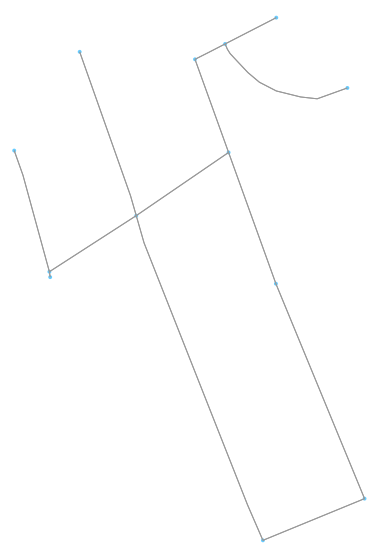

(<Figure size 619.923x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0eefa6f390>)

In [4]:
ox.plot_graph(bbox_graph, fig_height=10)

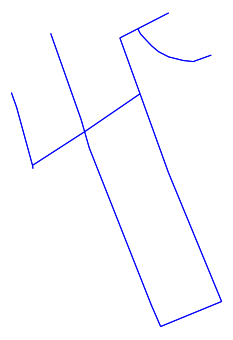

(<Figure size 371.954x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0ef01d11d0>)

In [5]:
ec = ['r' if data['oneway'] else 'b' for u, v, key, data in bbox_graph.edges(keys=True, data=True)]
ox.plot_graph(bbox_graph, node_size=0, edge_color=ec)

In [6]:
list(bbox_graph.edges(keys=True, data=True))

[(5441299616,
  63334966,
  0,
  {'osmid': 56629163,
   'name': 'North Nelson Street',
   'highway': 'residential',
   'oneway': False,
   'length': 1.843}),
 (5441299617,
  63334966,
  0,
  {'osmid': 56629163,
   'name': 'North Nelson Street',
   'highway': 'residential',
   'oneway': False,
   'length': 42.328,
   'geometry': <shapely.geometry.linestring.LineString at 0x7f0eefac45f8>}),
 (5441299822,
  5600335194,
  0,
  {'osmid': 8795539,
   'name': 'North Monroe Street',
   'highway': 'residential',
   'oneway': False,
   'length': 33.203}),
 (5441299822,
  63334543,
  0,
  {'osmid': 8795539,
   'name': 'North Monroe Street',
   'highway': 'residential',
   'oneway': False,
   'length': 46.794}),
 (5441299822,
  5441299823,
  0,
  {'osmid': 564838353,
   'highway': 'service',
   'oneway': False,
   'length': 37.521}),
 (5441299823,
  5441299822,
  0,
  {'osmid': 564838353,
   'highway': 'service',
   'oneway': False,
   'length': 37.521}),
 (5441299823,
  63334966,
  0,
  {'osmid':

In [9]:
bbox_graph.edges(keys=True, data=True)
# 566395910

OutMultiEdgeDataView([(5441299616, 63334966, 0, {'osmid': 56629163, 'name': 'North Nelson Street', 'highway': 'residential', 'oneway': False, 'length': 1.843}), (5441299617, 63334966, 0, {'osmid': 56629163, 'name': 'North Nelson Street', 'highway': 'residential', 'oneway': False, 'length': 42.328, 'geometry': <shapely.geometry.linestring.LineString object at 0x7f0eefac45f8>}), (5441299822, 5600335194, 0, {'osmid': 8795539, 'name': 'North Monroe Street', 'highway': 'residential', 'oneway': False, 'length': 33.203}), (5441299822, 63334543, 0, {'osmid': 8795539, 'name': 'North Monroe Street', 'highway': 'residential', 'oneway': False, 'length': 46.794}), (5441299822, 5441299823, 0, {'osmid': 564838353, 'highway': 'service', 'oneway': False, 'length': 37.521}), (5441299823, 5441299822, 0, {'osmid': 564838353, 'highway': 'service', 'oneway': False, 'length': 37.521}), (5441299823, 63334966, 0, {'osmid': 564838353, 'highway': 'service', 'oneway': False, 'length': 34.669}), (5441299823, 54412

In [11]:
bbox_graph.edges.items()

ItemsView(OutMultiEdgeView([(5441299616, 63334966, 0), (5441299617, 63334966, 0), (5441299822, 5600335194, 0), (5441299822, 63334543, 0), (5441299822, 5441299823, 0), (5441299823, 5441299822, 0), (5441299823, 63334966, 0), (5441299823, 5441299824, 0), (5441299823, 5441299828, 0), (5441299824, 5441299823, 0), (5441299828, 63327691, 0), (5441299828, 5441299823, 0), (63334543, 5441299822, 0), (63334543, 63327691, 0), (2219272722, 5662408421, 0), (63334966, 5441299616, 0), (63334966, 5441299823, 0), (63334966, 5441299617, 0), (5600335178, 5662408421, 0), (5600335194, 5441299822, 0), (5600335194, 5662408421, 0), (63327691, 5441299828, 0), (63327691, 63334543, 0), (5662408421, 2219272722, 0), (5662408421, 5600335178, 0), (5662408421, 5600335194, 0)]))

In [12]:
bbox_graph.nodes(data=True)[5441299616]

{'y': 38.8808526, 'x': -77.1030179, 'osmid': 5441299616}

In [13]:
bbox_graph[5441299616].items()

ItemsView(AdjacencyView({63334966: {0: {'osmid': 56629163, 'name': 'North Nelson Street', 'highway': 'residential', 'oneway': False, 'length': 1.843}}}))

In [14]:
from collections import defaultdict

In [15]:
def make_dict():
    return {'in':[],'out':[]}

In [16]:
in_out = defaultdict(make_dict)
for start, end in bbox_graph.edges():
    in_out[end]['in'].append(start)
    in_out[start]['out'].append(end)
in_out

defaultdict(<function __main__.make_dict()>,
            {63334966: {'in': [5441299616, 5441299617, 5441299823],
              'out': [5441299616, 5441299823, 5441299617]},
             5441299616: {'in': [63334966], 'out': [63334966]},
             5441299617: {'in': [63334966], 'out': [63334966]},
             5600335194: {'in': [5441299822, 5662408421],
              'out': [5441299822, 5662408421]},
             5441299822: {'in': [5441299823, 63334543, 5600335194],
              'out': [5600335194, 63334543, 5441299823]},
             63334543: {'in': [5441299822, 63327691],
              'out': [5441299822, 63327691]},
             5441299823: {'in': [5441299822, 5441299824, 5441299828, 63334966],
              'out': [5441299822, 63334966, 5441299824, 5441299828]},
             5441299824: {'in': [5441299823], 'out': [5441299823]},
             5441299828: {'in': [5441299823, 63327691],
              'out': [63327691, 5441299823]},
             63327691: {'in': [5441299828, 6333